# レスラー方程式のサブシステムの予測（外力あり）．

In [65]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs


In [66]:
#def reset_esn()の定義
#reset_esn()は一体何に使うのか？

def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [67]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [68]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

# 位相シフトの関数を定義します。
def phase_shift(t):
    shift_value = (8/24)*2*np.pi
    number_of_shifts = int(t / (4*2*np.pi))
    return number_of_shifts * shift_value

# 外力の関数を定義します。
def external_force(t, D, omega):
    return D * np.sin(omega * t + phase_shift(t))

# 外力が加わるレスラー方程式を定義します。
def rossler_with_force(t, state, a, b, c, D, omega):
    x, y, z = state
    dxdt = -y - z + external_force(t, D, omega)  # x成分に外力項を追加
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]


# パラメータと初期状態を設定します。
a, b, c = 0.2, 0.2, 5.7
D = 2.0  # 外力の振幅
omega = 1.0  # 外力の角周波数
initial_state = [1.0, 1.0, 1.0]

# 時間範囲を設定します。
t_span = (0, 2510)
t_eval = np.linspace(t_span[0], t_span[1], 25100)

# 外力が加わるレスラー方程式を解きます。
solution = solve_ivp(rossler_with_force, t_span, initial_state, args=(a, b, c, D, omega), t_eval=t_eval, max_step=0.01)

# 解を取得します。
t = solution.t
X = solution.y[0]
Y = solution.y[1]
Z = solution.y[2]
F_t = [external_force(ti, D, omega) for ti in t]  # 外力を評価します。

# 五次元配列に結果を格納します。
data_5d = np.array([t, X, Y, Z, F_t]).T

# CSVファイルに保存します。
df = pd.DataFrame(data_5d, columns=['Time', 'X', 'Y', 'Z', 'External_Force'])
df.to_csv('rossler_with_external_force.csv', index=False)

# CSVファイルを読み込む
data_loaded = pd.read_csv('rossler_with_external_force.csv')

In [69]:
rossler_data = data_loaded[['X', 'Y', 'Z']].copy()  # これでデータフレームとして定義します
rossler_data['Time'] = data_loaded['Time']  # 時間データを追加します

In [70]:
X_sub_names = data_loaded[['X', 'Y', 'External_Force']]
X_sub_names

,X,Y,External_Force
0,1.000000,1.000000,0.000000
1,0.823836,1.111965,0.199675
2,0.686475,1.210453,0.397354
3,0.577914,1.298573,0.591063
4,0.491501,1.378668,0.778866
...,...,...,...
25095,0.248769,-0.600325,1.015457
25096,0.397049,-0.579694,0.838360
25097,0.524326,-0.544706,0.652886
25098,0.628502,-0.497301,0.460889


In [71]:
X_sub = X_sub_names.values
X_sub

array([[ 1.        ,  1.        ,  0.        ],
       [ 0.82383551,  1.11196507,  0.19967476],
       [ 0.686475  ,  1.21045273,  0.39735428],
       ...,
       [ 0.52432565, -0.54470564,  0.65288643],
       [ 0.62850165, -0.49730121,  0.46088851],
       [ 0.70788445, -0.43965175,  0.26428519]])

In [72]:
seed_timesteps = 100
nb_generations = 400

In [73]:
train_len = 2000 
forecast=1 
    
n, m = X_sub.shape
    
from reservoirpy.datasets import to_forecasting

train_len = train_len

x, y = to_forecasting(X_sub, forecast=forecast)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

dataset = ((X_train, y_train), (X_test, y_test))

# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.059936189081400526
lr = 0.38264094967620654
ridge = 1.8102732550311867e-05
seed = 1234
sr = 0.07966435869333038

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                    sr=sr, 
                    lr=lr, 
                    input_scaling=iss, 
                    seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

In [74]:
seed_timesteps = seed_timesteps
nb_generations = 1500
#実際は150ステップに対応

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．

[ 7.86375279 -3.23730789  1.06226368]:warming_out[-1]
[ 7.83155509 -3.23908238  1.07733818]:X_test[seed_timesteps]


In [75]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した

(3,)
(1, 3)


In [80]:
X_sub_names

,X,Y,External_Force
0,1.000000,1.000000,0.000000
1,0.823836,1.111965,0.199675
2,0.686475,1.210453,0.397354
3,0.577914,1.298573,0.591063
4,0.491501,1.378668,0.778866
...,...,...,...
25095,0.248769,-0.600325,1.015457
25096,0.397049,-0.579694,0.838360
25097,0.524326,-0.544706,0.652886
25098,0.628502,-0.497301,0.460889


In [76]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = model(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]

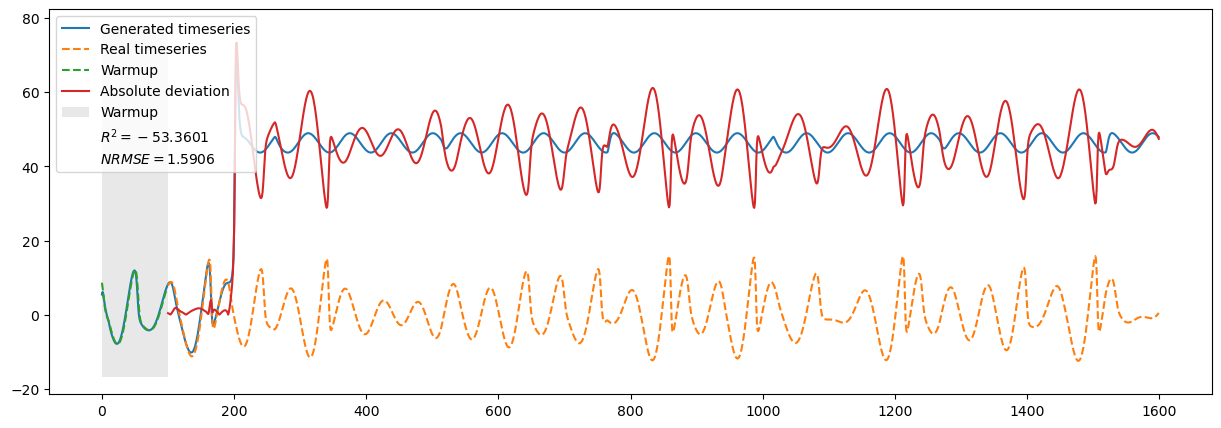

In [77]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

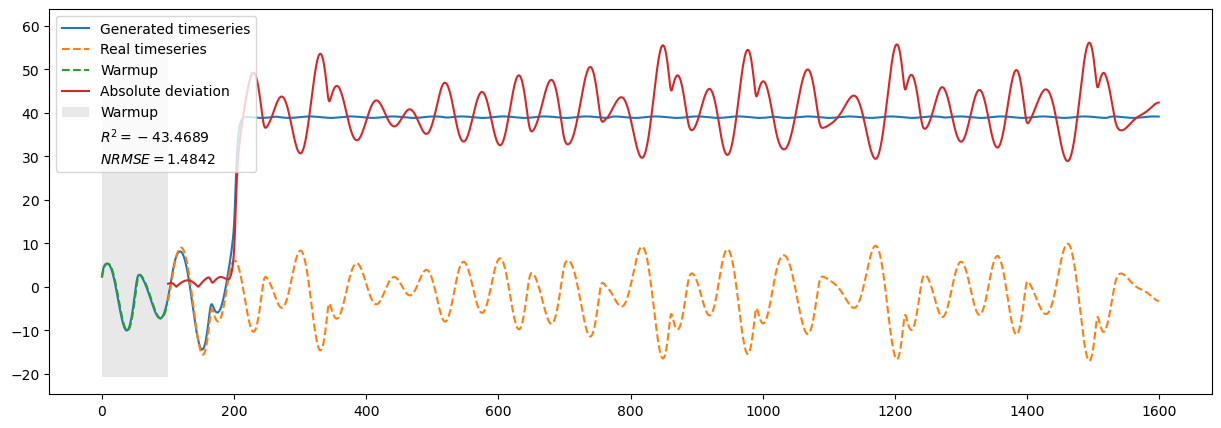

In [78]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


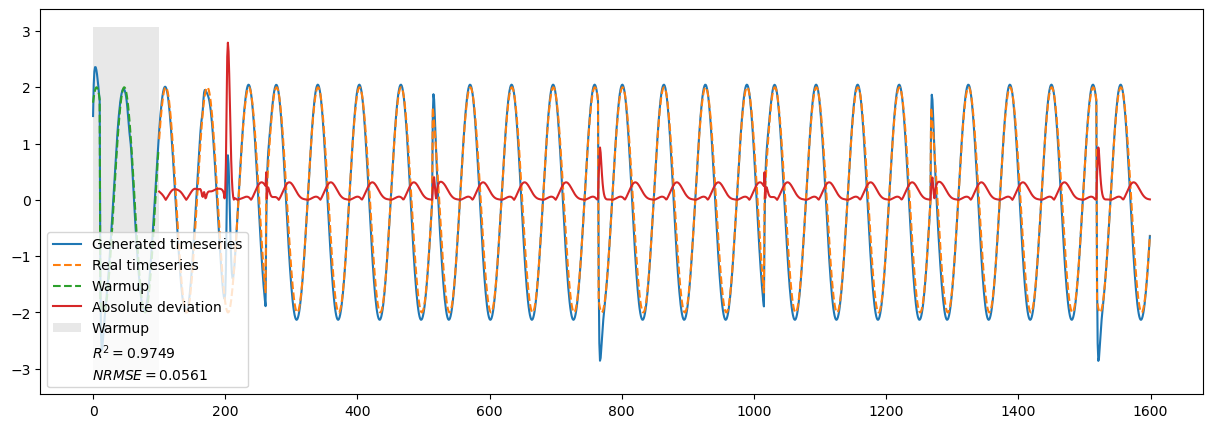

In [79]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)
